In [1]:
from tools import utils, config, trainer, parts
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from torch.nn import functional as F
from tools import utils

plt.style.use('fast')
PLOT_DIR = 'plots'

cfg = config.from_yaml("experiments\exp1_supervised_all\config.yaml")
dataset = utils.load_dataset_module(**cfg.data_supervised)
dataset.torch_seed()
test_loader = dataset.get_test_loader(**cfg.data_supervised)
test_dataset = dataset.get_test_dataset()

# Trained model
model_trained = utils.load_model(**cfg.model)
model_trained.load_state_dict(torch.load("experiments\exp1_supervised_all\checkpoint.pth"))

part_manager_trained = parts.PartManager(model_trained)
part_manager_trained.enable_all()

trn_trained = trainer.ModelTrainer(model_trained, cfg.trainer_sup, part_manager_trained)

Loading dataset: data\cifar10.py
Files already downloaded and verified
Files already downloaded and verified
Created 5 parts.
Enable all parts
checkpoint to cuda:0


In [30]:
import torchattacks
adv_y = []

correct = 0
n_examples = 0

atk = torchattacks.PGD(model_trained, eps=8/255, alpha=2/255, steps=4)
adv_images = None
y = None
adv_pred = None

for x, y in test_loader:
    x.to(trn_trained.device)
    y.to(trn_trained.device)
    n_examples += x.shape[0]
    adv_images = atk(x, y) # x.to(trn_trained.device)
    adv_pred = model_trained(adv_images).data.max(1, keepdim=True)[1].cpu()
    correct += adv_pred.eq(y.data.view_as(adv_pred)).sum()
    
acc = correct / n_examples
acc

D:\Miniconda3\envs\env\lib\site-packages\torch\nn\modules\module.py:1102: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return forward_call(*input, **kwargs)


tensor(0.1199)

Text(0.5, 1.0, 'label: 3 pred: 8')

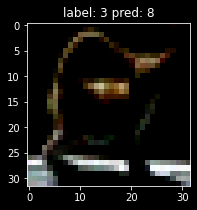

In [37]:
i_example = 0

plt.figure(figsize=(3, 3))
plt.imshow(adv_images.cpu().detach().numpy()[i_example].transpose([1, 2, 0]))
plt.title("label: " + str(y.detach().numpy()[i_example]) + ' pred: ' + str(adv_pred.detach().numpy()[i_example][0]))

tensor(0.7552)

In [38]:
part_manager_trained.parts[1].get_conv_layer().weight.shape

torch.Size([80, 40, 3, 3])